# COMP0189: Applied Artificial Intelligence
## Week 7 (Model Interpretation and Feature selection)


## Learning goals 🎯
1. Learn how to properly implement feature selection to avoid leaking information.
2. Learn how to use different strategies for interpreting machine learning models.

### Acknowledgements
- https://scikit-learn.org/stable/
- https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#id1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

# Part 1: A common error: leaking information

We will start with a toy example to illustrate a common mistake when using feature selection. We will create a random dataset with 10.000 features and 100 samples.

In [2]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
X_test = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))
y_test = rnd.normal(size=(100,))

In [3]:
print(X.shape)

(100, 10000)


We might consider that 10.000 is a very high number of features and that we need to use feature selection. So, let's select the 5% most informative features.

In [4]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import RidgeCV

select = SelectPercentile(score_func=f_regression,
                          percentile=5)
select.fit(X, y)
X_sel = select.transform(X)

print(X_sel.shape)

(100, 500)


Now we will create a pipeline to pre-process the data and fit a regression model to see if we can predict the random labels from the selected features.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, random_state=0)
pipe = make_pipeline(StandardScaler(), Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9047168401499722

These are great results but how did we get such good results on a random dataset?

These results are due to information leaking.

### Task 1: Implement a correct pipeline to pre-process the data, select the top 5% features and train a regression model to predict th random labels.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = make_pipeline(StandardScaler(), select,  Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

-0.03695402379065271

These results make more sense from what we would expet with random labels.

# Part 2: Model interpretation and feature selection


For this part we will use data from the “Current Population Survey” from 1985 to predict wage as a function of various features such as experience, age, or education.

We fetch the data from OpenML. Note that setting the parameter as_frame to True will retrieve the data as a pandas dataframe.

In [7]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Now we identify features X and targets y: the column WAGE is our target variable (i.e., the variable which we want to predict).

In [8]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Note that the dataset contains categorical and numerical variables. We will need to take this into account when preprocessing the dataset thereafter.

In [9]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


Our target for prediction: the wage. Wages are described as floating-point number in dollars per hour.


In [10]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

We now split the sample into a train and a test dataset. Only the train dataset will be used in the following exploratory analysis. This is a way to emulate a real situation where predictions are performed on an unknown target, and we don’t want our analysis and decisions to be biased by our knowledge of the test data.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let’s get some insights by looking at the variable distributions and at the pairwise relationships between them. Only numerical variables will be used. In the following plot, each dot represents a sample.

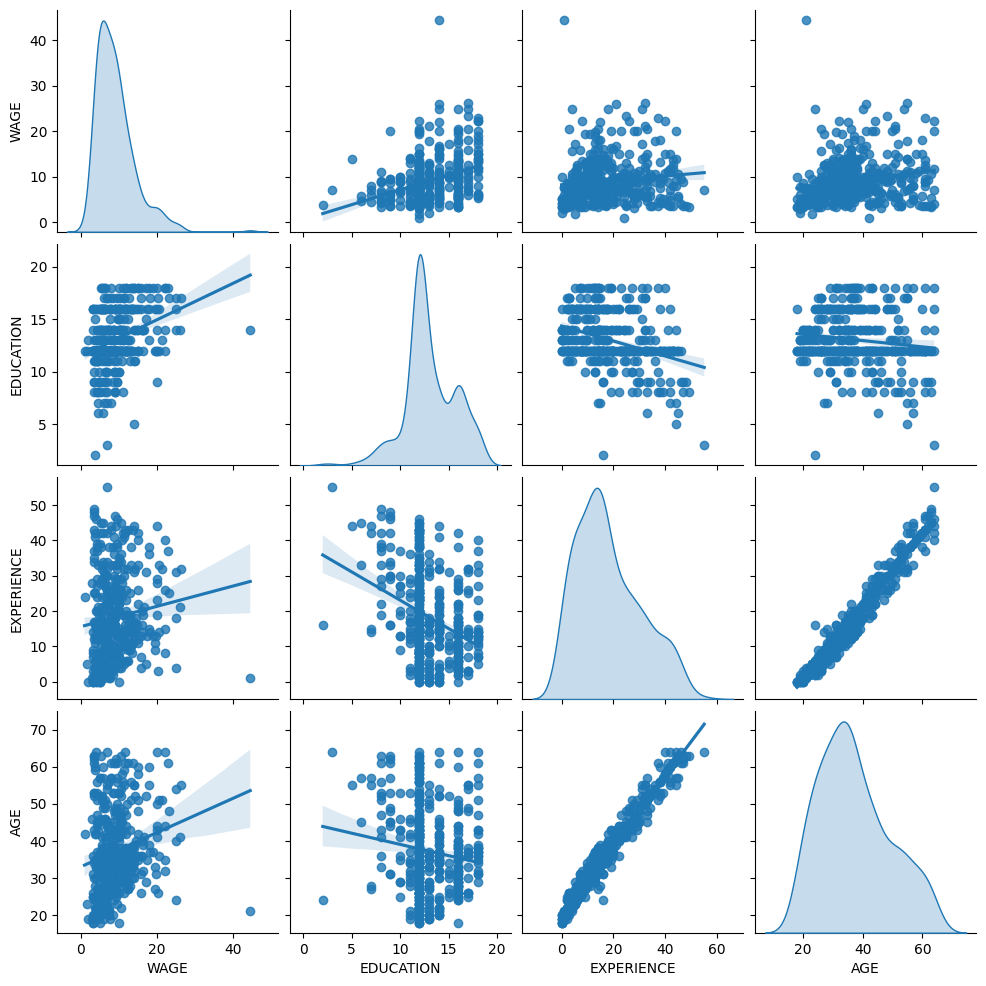

In [12]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

Looking closely at the WAGE distribution reveals that it has a long tail. For this reason, we should take its logarithm to turn it approximately into a normal distribution (linear models such as ridge or lasso work best for a normal distribution of error).

The WAGE is increasing when EDUCATION is increasing. Note that the dependence between WAGE and EDUCATION represented here is a marginal dependence, i.e., it describes the behavior of a specific variable without keeping the others fixed.

Also, the EXPERIENCE and AGE are strongly linearly correlated.



Before design a machine learning pipeline, we should check the type of data that we are dealing with:

In [13]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.2 KB


As seen previously, the dataset contains columns with different data types and we need to apply a specific preprocessing for each data types.

## Task 2: Implement a machine learning pipeline that includes pre-processing and cross-validation to optimize the models hyperparameters and use the pipeline with rigde regression, Lasso and elastic-net regression regression to predict the wages from the other features.



In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge,RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
   (StandardScaler(), numerical_columns),
    verbose_feature_names_out=False,
)


alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model_Ridge= make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model_Ridge.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [15]:
model_Ridge[-1].regressor_.alpha_

10.0

In [16]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model_Lasso= make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model_Lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                                                              max_iter=100000)))])

In [17]:
model_Lasso[-1].regressor_.alpha_

0.001

In [18]:
from sklearn.linear_model import ElasticNetCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model_EN= make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=ElasticNetCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model_EN.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=ElasticNetCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                                                                   max_iter=100000)))])

In [19]:
model_EN[-1].regressor_.alpha_

0.001

### Task 2.1 Check the performance of the computed models plotting its predictions on the test set and computing the median absolute error of the model.

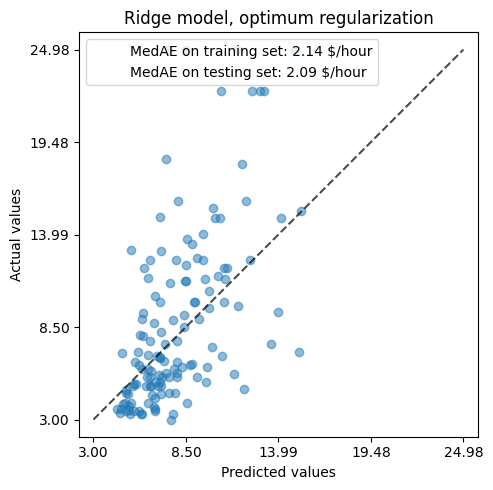

In [20]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model_Ridge.predict(X_train))
y_pred = model_Ridge.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

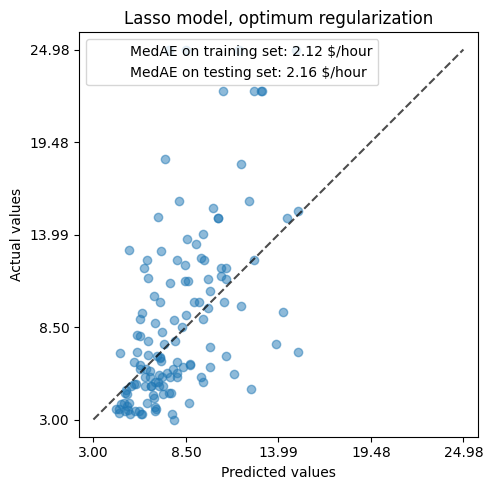

In [21]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model_Lasso.predict(X_train))
y_pred = model_Lasso.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()


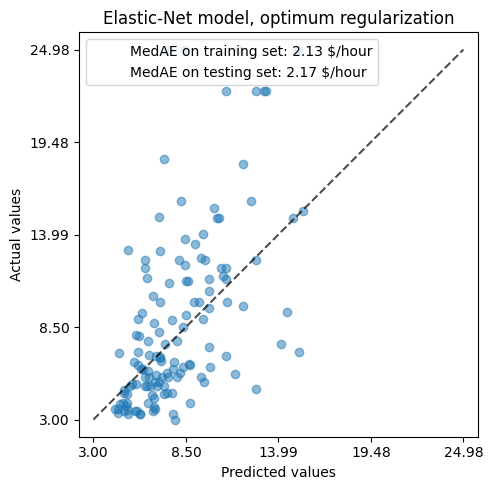

In [22]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model_EN.predict(X_train))
y_pred = model_EN.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Elastic-Net model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

### Task 2.2 Plot the models coefficientes variability across folds for the linear models.

In [23]:
from sklearn.model_selection import RepeatedKFold, cross_validate
feature_names = model_Ridge[:-1].get_feature_names_out()
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model_Ridge,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

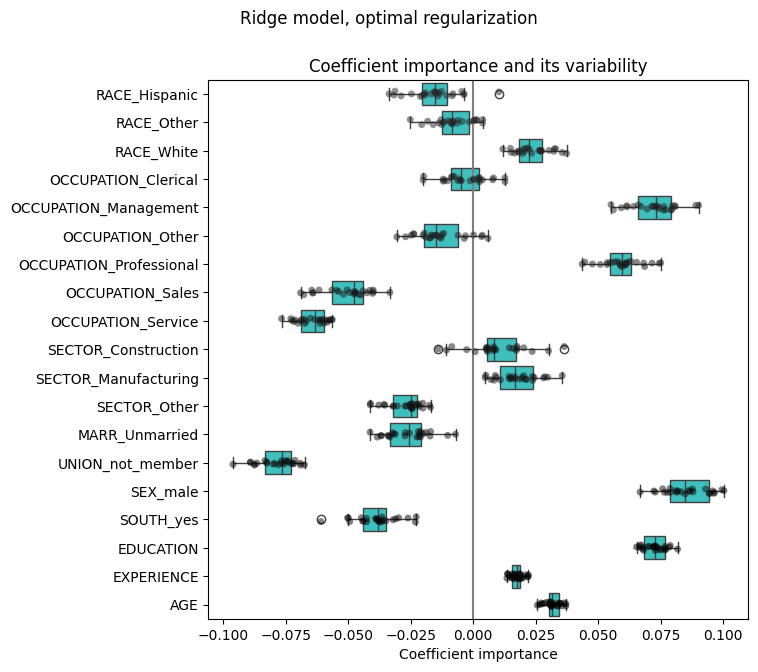

In [24]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, optimal regularization")
plt.subplots_adjust(left=0.3)

In [25]:
from sklearn.model_selection import RepeatedKFold, cross_validate
feature_names = model_Lasso[:-1].get_feature_names_out()
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model_Lasso,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

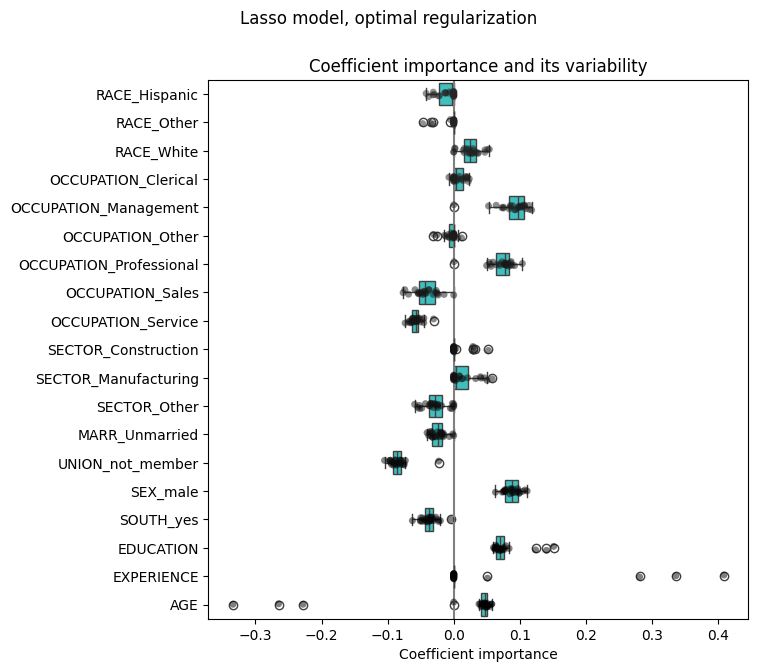

In [26]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Lasso model, optimal regularization")
plt.subplots_adjust(left=0.3)

In [27]:
from sklearn.model_selection import RepeatedKFold, cross_validate
feature_names = model_EN[:-1].get_feature_names_out()
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model_EN,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

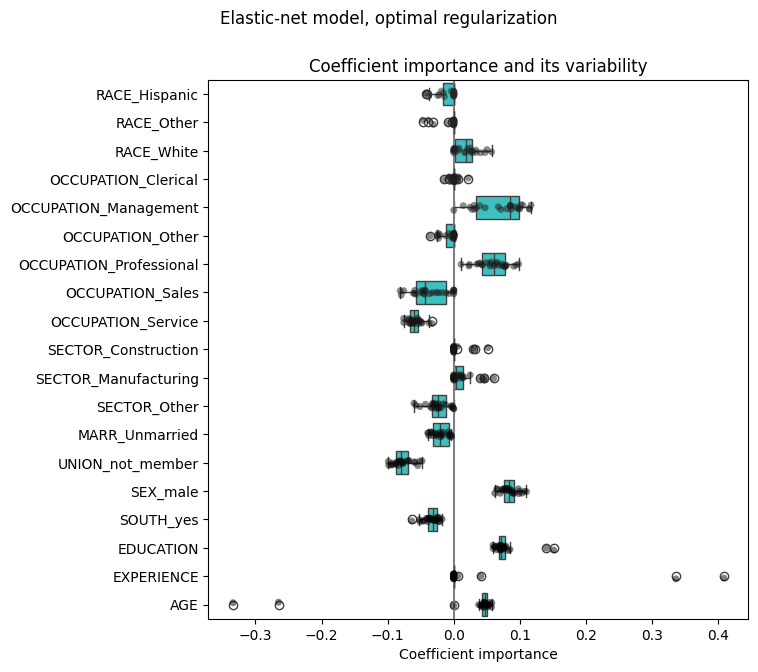

In [28]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Elastic-net model, optimal regularization")
plt.subplots_adjust(left=0.3)

Discussion: Are the coefficents across the different models similar?

### Task 2.3 Plot the permutation feature importance for the different models.

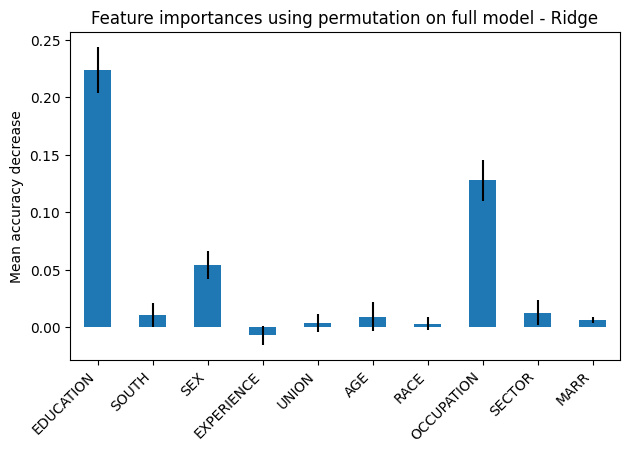

In [29]:
from sklearn.inspection import permutation_importance

feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature {i}" for i in range(X_test.shape[1])]

result = permutation_importance(
    model_Ridge, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model - Ridge")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.xticks(rotation=45, ha="right")

plt.show()

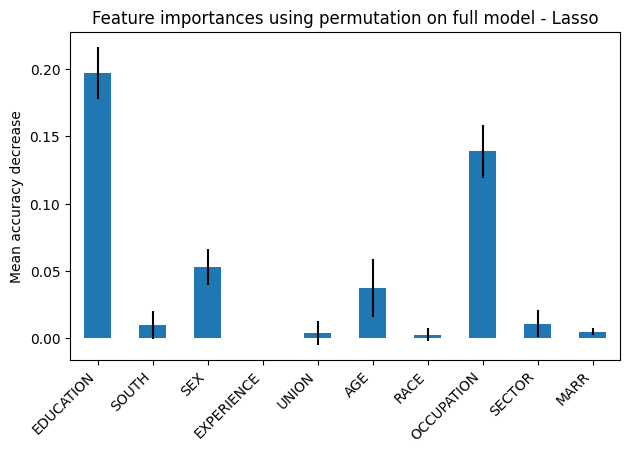

In [30]:
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature {i}" for i in range(X_test.shape[1])]

result = permutation_importance(
    model_Lasso, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model - Lasso")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.xticks(rotation=45, ha="right")

plt.show()

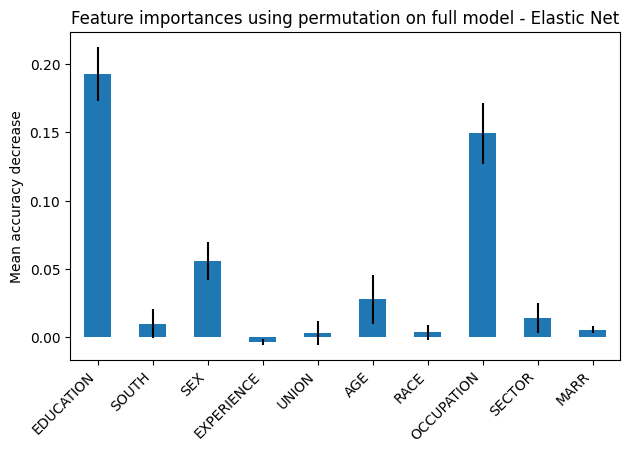

In [31]:
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature {i}" for i in range(X_test.shape[1])]

result = permutation_importance(
    model_EN, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model - Elastic Net")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.xticks(rotation=45, ha="right")

plt.show()

Discussion: Are the feature coefficients simimar to the permutation importance for the different models?

### Task 2.4 Implement a similar pipeline for tree-based models and use the pipeline with random-forest and boosted regression trees to predict the wages from the other features.

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
import numpy as np
import scipy as sp

# Random Forest Model
rf_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RandomForestRegressor(max_depth=4, random_state=0),
        func=np.log10,  # Applying log transformation to the target variable
        inverse_func=sp.special.exp10,  # Applying the inverse transformation for prediction
    ),
)

rf_model.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RandomForestRegressor(max_depth=4,
                                                                            random_state=0)))])

In [33]:
# Gradient Boosting Model
gb_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                             max_depth=3, random_state=0),
        func=np.log10,  # Applying log transformation to the target variable
        inverse_func=sp.special.exp10,  # Applying the inverse transformation for prediction
    ),
)
gb_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=GradientBoostingRegressor(random_state=0)))])

### Task 2.5 Check the performance of the tree-based models plotting its predictions on the test set and computing the median absolute error of the model.

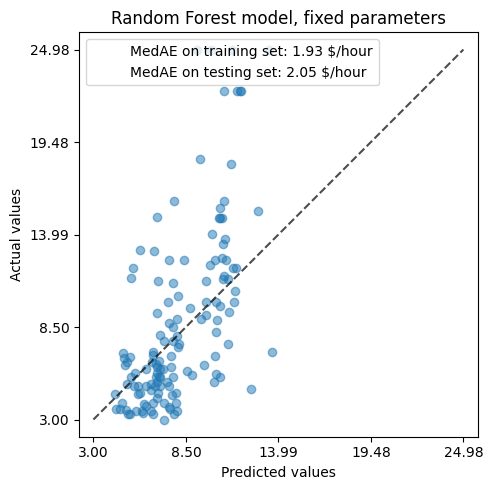

In [34]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, rf_model.predict(X_train))
y_pred = rf_model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Random Forest model, fixed parameters")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

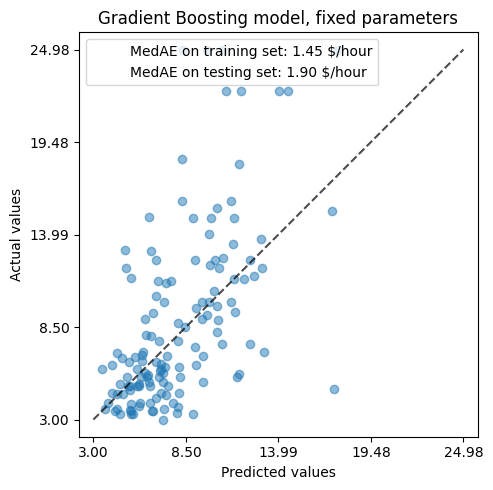

In [35]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, gb_model.predict(X_train))
y_pred = gb_model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Gradient Boosting model, fixed parameters")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

### Task 2.6 Plot the feature importance for the different tree-based models

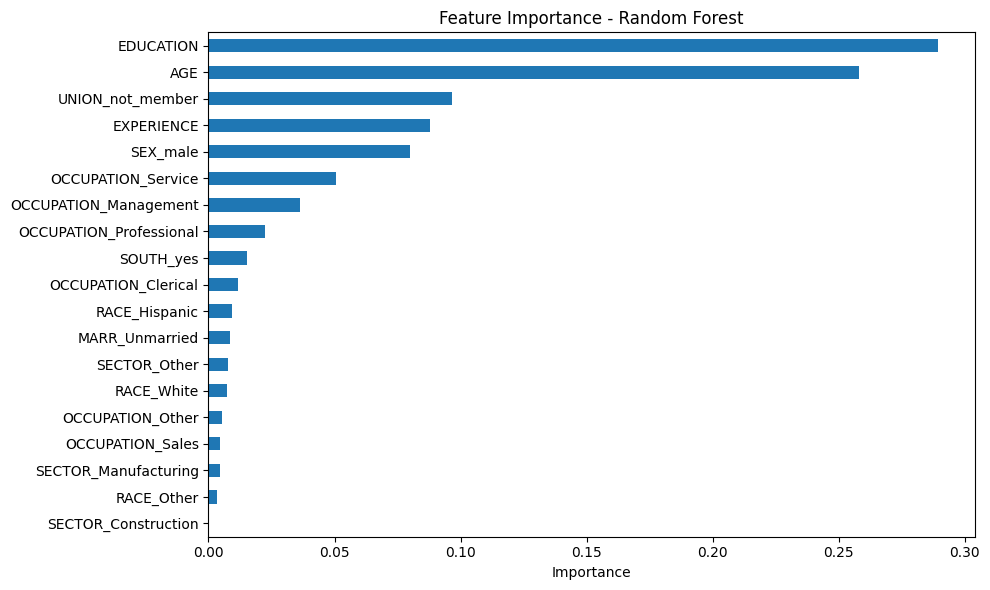

In [36]:
# Access the RandomForestRegressor object inside the TransformedTargetRegressor which is inside the pipeline
random_forest_regressor = rf_model.named_steps['transformedtargetregressor'].regressor_

# Get feature importances
feature_importances = random_forest_regressor.feature_importances_


feature_names = preprocessor.get_feature_names_out()


# Create a pandas series with feature importances
importances_series = pd.Series(feature_importances, index=feature_names)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
importances_series.sort_values().plot.barh(ax=ax)
ax.set_title("Feature Importance - Random Forest")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

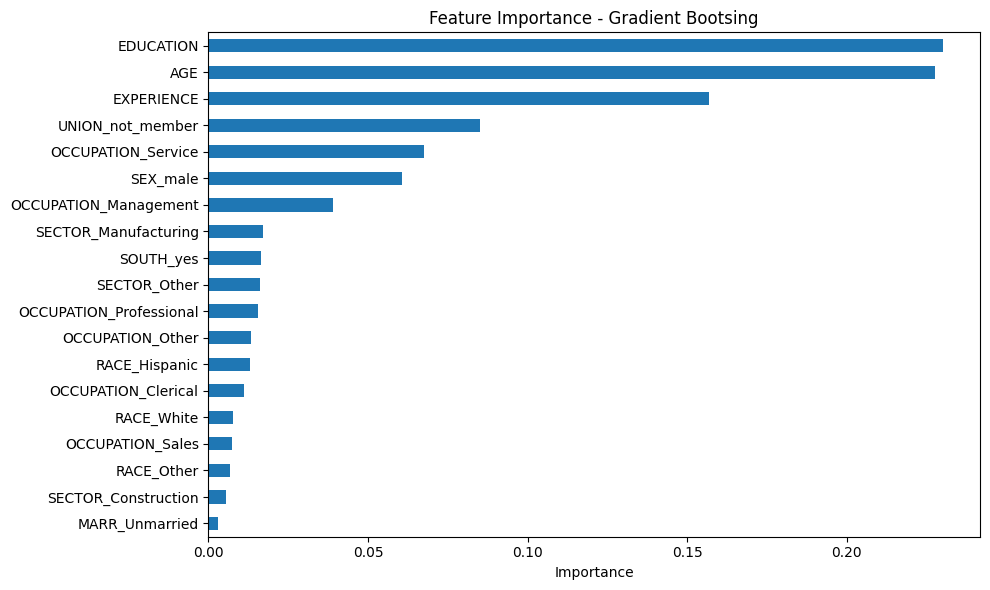

In [37]:
# Access the RandomForestRegressor object inside the TransformedTargetRegressor which is inside the pipeline
random_forest_regressor = gb_model.named_steps['transformedtargetregressor'].regressor_

# Get feature importances
feature_importances = random_forest_regressor.feature_importances_


feature_names = preprocessor.get_feature_names_out()


# Create a pandas series with feature importances
importances_series = pd.Series(feature_importances, index=feature_names)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
importances_series.sort_values().plot.barh(ax=ax)
ax.set_title("Feature Importance - Gradient Bootsing")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

### Task 2.7 Plot the permutation feature importance for the different tree-based models

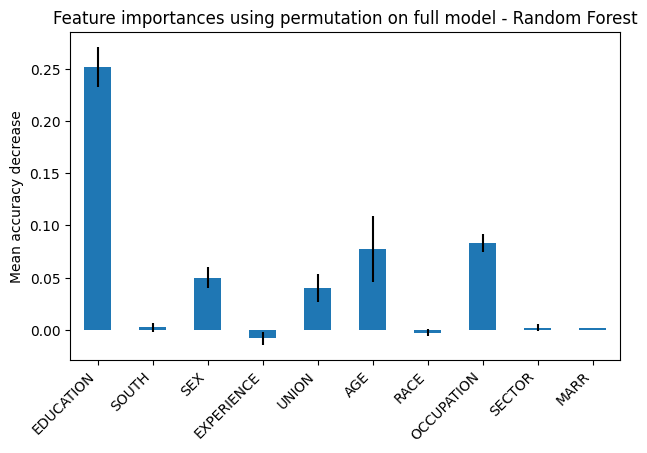

In [38]:
from sklearn.inspection import permutation_importance


feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature {i}" for i in range(X_test.shape[1])]

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model - Random Forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.xticks(rotation=45, ha="right")
plt.show()



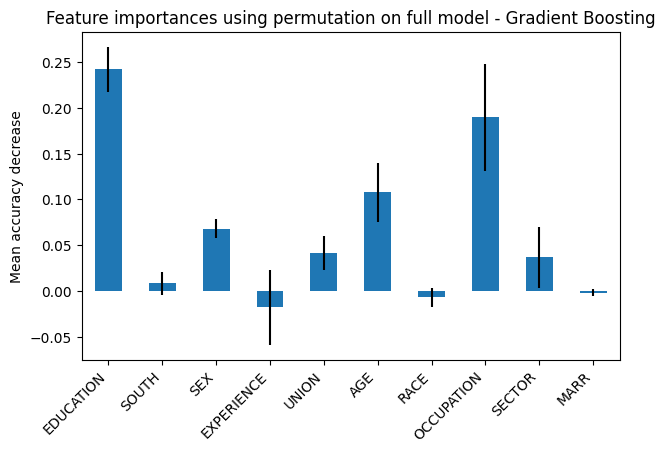

In [39]:

feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature {i}" for i in range(X_test.shape[1])]

result = permutation_importance(
    gb_model, X_test, y_test, n_repeats=4, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model - Gradient Boosting")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.xticks(rotation=45, ha="right")
plt.show()

Discussion: Are the feature importance and permutation feature importance similar for the different models?

### Task 2.8  For the best tree-based model use partial dependence plot to investigate dependence between the target response and each feature

In [40]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predictions from Gradient Boosting model
y_pred_gb = gb_model.predict(X_test)

# Predictions from Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Compute R² score
r2_gb = r2_score(y_test, y_pred_gb)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute Mean Absolute Error
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Gradient Boosting R² Score: {r2_gb:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")

print(f"Gradient Boosting MAE: {mae_gb:.4f} $/hour")
print(f"Random Forest MAE: {mae_rf:.4f} $/hour")


Gradient Boosting R² Score: 0.3142
Random Forest R² Score: 0.3254
Gradient Boosting MAE: 2.9673 $/hour
Random Forest MAE: 2.9921 $/hour


In [52]:
# refer to documentation ... create list of categories which signal which features are categorical

# Get the list of all feature names
feature_names = X_train.columns.tolist()

# Get the list of numeric feature names
numeric_feature_names = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Initialize an empty list to store the boolean values
is_categorical = []

# Iterate over all feature names
for feature in feature_names:
    # If the feature is not in the list of numeric features, it is categorical
    if feature not in numeric_feature_names:
        is_categorical.append(True)
    else:
        is_categorical.append(False)


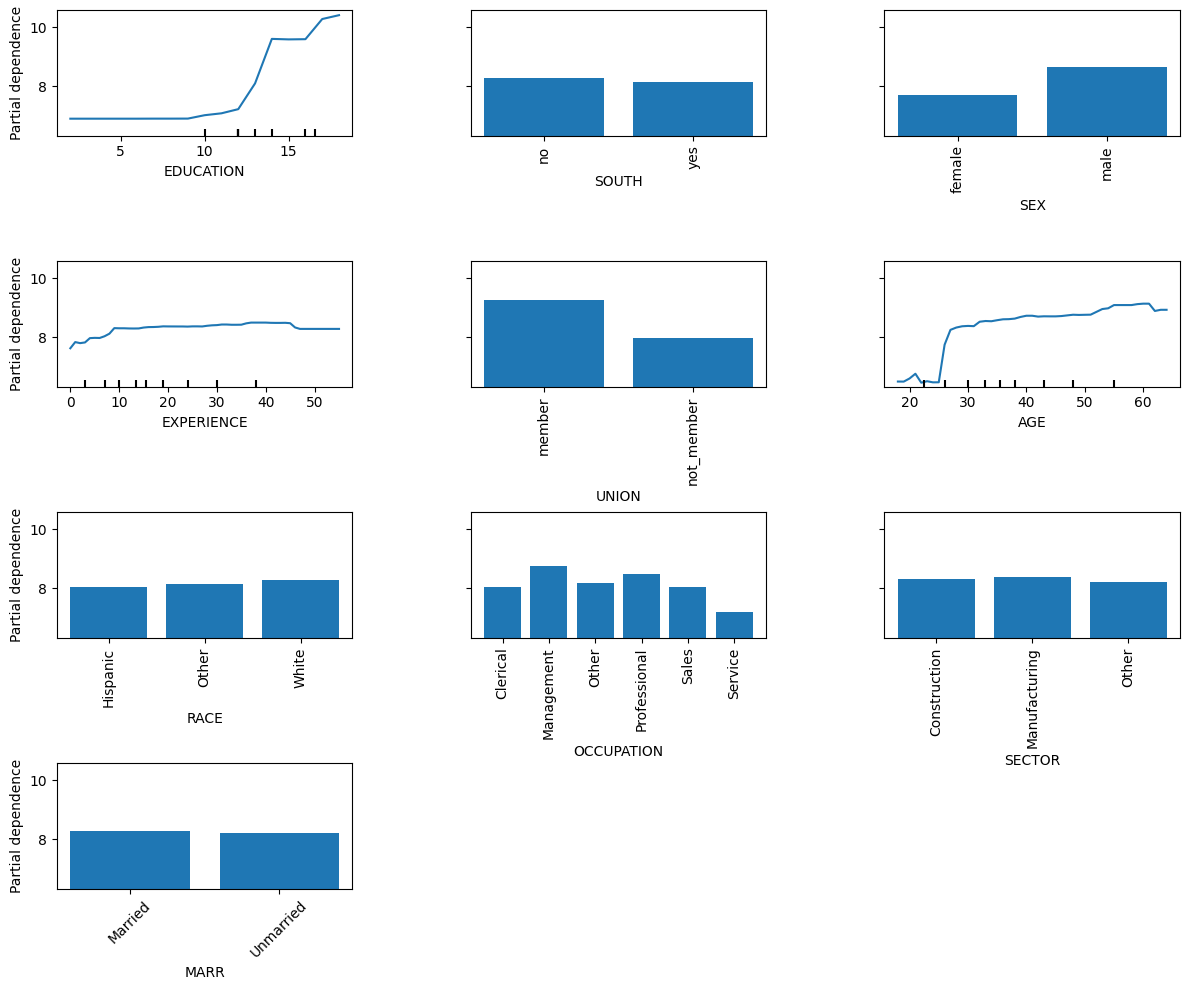

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Generate partial dependence plots for selected features using the entire pipeline
fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted figure size
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=feature_names, kind='average', ax=ax, categorical_features=is_categorical)

plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.subplots_adjust(bottom=0.2, hspace=1, wspace=0.4)  # Adjust spacing
plt.tight_layout()  # Adjust layout

plt.show()



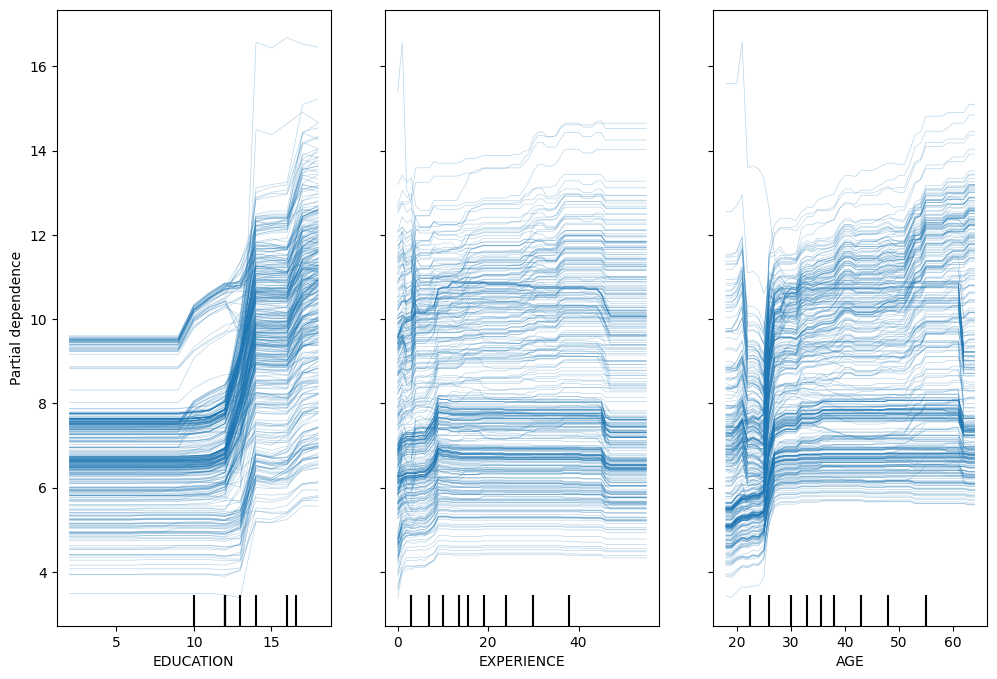

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Individual (only for numeric)

# Generate partial dependence plots for selected features using the entire pipeline
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=numeric_feature_names, kind='individual', ax=ax)

plt.show()

## Task 3: Include feature selection within the cross-validation pipeline implemented in Task 1 and try two different feature selection strategies (select k best and recursive feature elimination) with the ridge regression model.

In [ ]:
from sklearn.feature_selection import RFECV,RFE,SelectKBest
from sklearn.svm import SVR


alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    RFE(SVR(kernel="linear")),
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    )
)
# selector = RFECV(model, cv=5)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('rfe', RFE(estimator=SVR(kernel='linear'))),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

### Task 3.1 Check the performance of the computed models plotting its predictions on the test set and computing the median absolute error of the model.

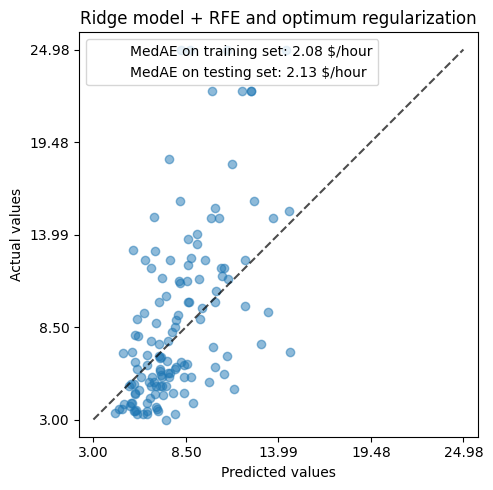

In [ ]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model + RFE and optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

Discussion: Did the model performance improved with feature selection?

### Task 3.2 Plot the coefficientes variability across folds for the linear model based on the selected features.

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
feature_names = model[:-1].get_feature_names_out()
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

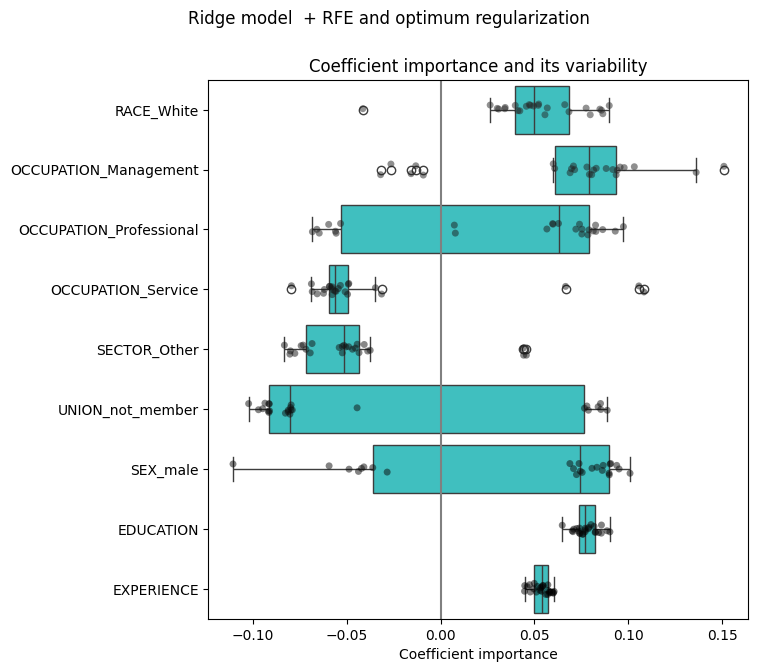

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model  + RFE and optimum regularization")
plt.subplots_adjust(left=0.3)

Discussion: Are similar features selected using the different strategies?